# Aula07 - Q-Learning e Sarsa

Sejam bem vindos ao notebook de Q-Learning e Sarsa!

Neste exercício vamos implementar os algoritmos Q-Learning e Sarsa com seleção de ação $\epsilon$-greedy. 

Ao final vamos investigar o desempenho destes métodos para o problema de Caminhada no Penhasco, já introduzido na aula passada.

Vamos fornecer o ambiente para execução dos experimentos (RL-Glue) e ao final visualizando a performance do aprendizado.

In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt
from rl_utils import BaseAgent
from rl_utils import Environment
from rl_utils import RLGlue
from tqdm.notebook import tqdm
import pickle

In [2]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [10,5]})

## Q-Learning

Nesta seção vamos implementar e testar um agente Q-Learning com seleção de ação $\epsilon$-greedy (seção 6.5 do livro).

### Implementação

A primeira tarefa consiste em implementar a atualização do agente *agent_step*.

In [3]:
class QLearningAgent(BaseAgent):
    def agent_init(self, agent_init_info):
        """Configuração do agente, chamado quando o experimento começa.
        Args:
        agent_init_info (dict), parâmetros utilizados para inicializar o agente.
        O dicionário contém:
        {
            num_states (int): Número de estados,
            num_actions (int): Número de ações,
            epsilon (float): Parâmetro epsilon para exploration,
            step_size (float): Learning-rate ou step-size,
            discount (float): O fator de desconto,
        }
        """
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_info["seed"])
        
        # Inicialização de Q.
        self.q = np.zeros((self.num_states, self.num_actions))

    def agent_start(self, state):
        """Primeiro método chamado quando o episódio começa. 
           Chamado após o ambiente começar.
        Args:
            state (int): O estado do ambiente.
        Returns:
            action (int): Primeira ação que o agente executa.
        """        
        # Escolhe ação seguindo epsilon greedy.
        current_q = self.q[state,:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state):
        """Um passo executado pelo agente.
        Args:
            reward (float): A recompensa recebida por ter tomado a última ação.
            state (int): Estado do ambiente.
        Returns:
            action (int): Ação que o agente irá tomar.
        """
        
        # Escolhe ação utilizando o epsilon greedy.
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(self.q[state, :])

        ### INÍCIO DO CÓDIGO.
        self.q[self.prev_state, self.prev_action] += self.step_size*(reward + self.discount*np.max(self.q[state, :]) - self.q[self.prev_state, self.prev_action])
        ### FIM DO CÓDIGO.
        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """Final do agente.
        Args:
            reward (float): Recompensa que o agente recebe por entrar no estado terminal.
        """
        # Última atualização no episódio.
        self.q[self.prev_state, self.prev_action] += self.step_size * (reward- self.q[self.prev_state, self.prev_action])
        
    def argmax(self, q_values):
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

In [4]:
# Célula de testes.
agent_info = {"num_actions": 4, "num_states": 3, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
current_agent = QLearningAgent()
current_agent.agent_init(agent_info)
action = current_agent.agent_start(0)
print("Estimativas das action-values: \n", current_agent.q)
print("Ação:", action)

Estimativas das action-values: 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Ação: 1


**Output Esperado:**

```
Estimativas das action-values: 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Ações: 1
```

In [5]:
# Célula de teste para agent_step()
actions = []
agent_info = {"num_actions": 4, "num_states": 3, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
current_agent = QLearningAgent()
current_agent.agent_init(agent_info)
actions.append(current_agent.agent_start(0))
actions.append(current_agent.agent_step(2, 1))
actions.append(current_agent.agent_step(0, 0))
print("Estimativas das action-values: \n", current_agent.q)
print("Ação:", actions)

Estimativas das action-values: 
 [[0.   0.2  0.   0.  ]
 [0.   0.   0.   0.02]
 [0.   0.   0.   0.  ]]
Ação: [1, 3, 1]


**Output Esperado:**

```
Estimativas das action-values: 
 [[ 0.   0.2  0.   0. ]
 [ 0.   0.   0.  0.02]
 [ 0.   0.   0.   0. ]]
Ações: [1, 3, 1]
```

## Sarsa

Nesta seção vamos implementar o agente Sarsa com seleção de ação $\epsilon$-greedy (Seção 6.6 do livro).

### Implementação

Como na seção anterior, sua tarefa é implementar a atualização no método *agent_step*.

In [6]:
class SarsaAgent(BaseAgent):
    def agent_init(self, agent_init_info):
        """Configuração do agente, chamado quando o experimento começa.
        
        Args:
        agent_init_info (dict), parâmetros utilizados para inicializar o agente.
        O dicionário contém:
        {
            num_states (int): Número de estados,
            num_actions (int): Número de ações,
            epsilon (float): Parâmetro epsilon para exploração,
            step_size (float): step-size,
            discount (float): Fator de desconto,
        }
        
        """
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_info["seed"])
        
        # Q
        self.q = np.zeros((self.num_states, self.num_actions))
        
    def agent_start(self, state):
        """Primeiro método chamado quando o episódio começa. 
           Chamado após o ambiente começar.
        Args:
            state (int): O estado do ambiente.
        Returns:
            action (int): Primeira ação que o agente executa.
        """
        current_q = self.q[state, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state):
        """Um passo executado pelo agente.
        Args:
            reward (float):  A recompensa recebida por ter tomado a última ação.
            state (int): Estado do ambiente.
        Returns:
            action (int): Ação que o agente irá tomar.
        """        
        # Escolhe ação utilizando o epsilon greedy.
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(self.q[state,:])

        ### INÍCIO DO CÓDIGO.
        self.q[self.prev_state, self.prev_action] += self.step_size * (reward + self.discount * (1 - self.epsilon) * np.max(self.q[state, :]) + self.epsilon * np.average(self.q[state, :]) - self.q[self.prev_state, self.prev_action])

        ### FIM DO CÓDIGO.
        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """Final do agente.
        Args:
            reward (float): Recompensa que o agente recebe por entrar no estado terminal.
        """
        self.q[self.prev_state, self.prev_action] += self.step_size * (reward- self.q[self.prev_state, self.prev_action])

    def argmax(self, q_values):
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

In [7]:
# Célula de teste.
agent_info = {"num_actions": 4, "num_states": 3, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
current_agent = SarsaAgent()
current_agent.agent_init(agent_info)
action = current_agent.agent_start(0)
print("Estimativas das action-values: \n", current_agent.q)
print("Ação:", action)

Estimativas das action-values: 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Ação: 1


**Output Esperado:**

```
Estimativas das action-values: 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Ações: 1
```

In [8]:
# Célula de testes para agent_step()
actions = []
agent_info = {"num_actions": 4, "num_states": 3, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
current_agent = SarsaAgent()
current_agent.agent_init(agent_info)
actions.append(current_agent.agent_start(0))
actions.append(current_agent.agent_step(2, 1))
actions.append(current_agent.agent_step(0, 0))
print("Estimativas das action-values: \n", current_agent.q)
print("Ações:", actions)

Estimativas das action-values: 
 [[0.     0.2    0.     0.    ]
 [0.     0.     0.     0.0185]
 [0.     0.     0.     0.    ]]
Ações: [1, 3, 1]


**Output Esperado:**

```
Estimativas das action-values: 
 [[0.     0.2    0.     0.    ]
 [0.     0.     0.     0.02]
 [0.     0.     0.     0.    ]]
Ações: [1, 3, 1]
```

## Resolvendo Cliff World. 

Para validar e entender o comportamento das duas implementações, vamos utilizar o ambiente que introduzimos na aula passada: Caminhada no Penhasco.

**Relembrando**: esta é uma tarefa episódica sem desconto e, portanto, definimos $ \ gamma $ = 1. O agente começa no canto inferior esquerdo do grid e executa ações que o movem nas quatro direções. Ações que levam o agente para o penhasco incorrem em uma recompensa $R=-100$ e enviam o agente de volta ao estado inicial. A recompensa para todas as outras transições é -1. 

Um episódio termina quando o agente chega ao canto inferior direito.

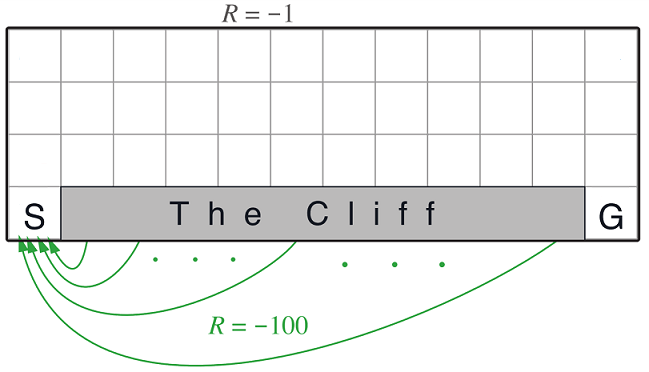


Usando a célula abaixo, comparamos os agentes no ambiente de Caminhada no Penhasco e traçamos a soma das recompensas durante cada episódio para os dois agentes. 

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

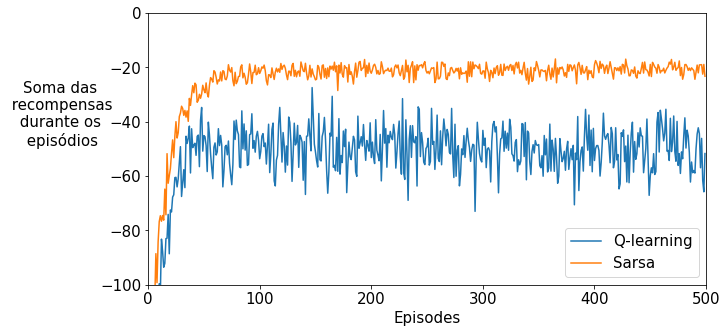

In [9]:
agents = {
    "Q-learning": QLearningAgent,
    "Sarsa": SarsaAgent
}
env = Environment
all_reward_sums = {}
all_state_visits = {}
agent_info = {"num_actions": 4, "num_states": 48, "epsilon": 0.1, "step_size": 0.5, "discount": 1.0}
env_info = {}
num_runs = 100
num_episodes = 500

for algorithm in ["Q-learning", "Sarsa"]:
    all_reward_sums[algorithm] = []
    all_state_visits[algorithm] = []
    for run in tqdm(range(num_runs)):    
        agent_info["seed"] = run
        rl_glue = RLGlue(env, agents[algorithm])
        rl_glue.rl_init(agent_info, env_info)

        reward_sums = []
        state_visits = np.zeros(48)
        for episode in range(num_episodes):
            if episode < num_episodes - 10:                
                rl_glue.rl_episode(0) 
            else:                 
                state, action = rl_glue.rl_start()
                state_visits[state] += 1
                is_terminal = False
                while not is_terminal:
                    reward, state, action, is_terminal = rl_glue.rl_step()
                    state_visits[state] += 1
                
            reward_sums.append(rl_glue.rl_return())
            
        all_reward_sums[algorithm].append(reward_sums)
        all_state_visits[algorithm].append(state_visits)

for algorithm in ["Q-learning", "Sarsa"]:
    plt.plot(np.mean(all_reward_sums[algorithm], axis=0), label=algorithm)
plt.xlabel("Episodes")
plt.ylabel("Soma das\n recompensas\n durante os \n episódios",rotation=0, labelpad=40)
plt.xlim(0,500)
plt.ylim(-100,0)
plt.legend()
plt.show()

Para visualizar o comportamento dos dois agentes, vamos inspecionar os estados que eles mais visitam.

Execute a célula abaixo para mostrar o número de passos que cada agente expendeu em cada uma das células nos últimos 10 episódios.

<ipython-input-10-86ada0003cff>:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cm.set_bad('gray')
<ipython-input-10-86ada0003cff>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cax = plt.axes([0.85, 0.0, 0.075, 1.])


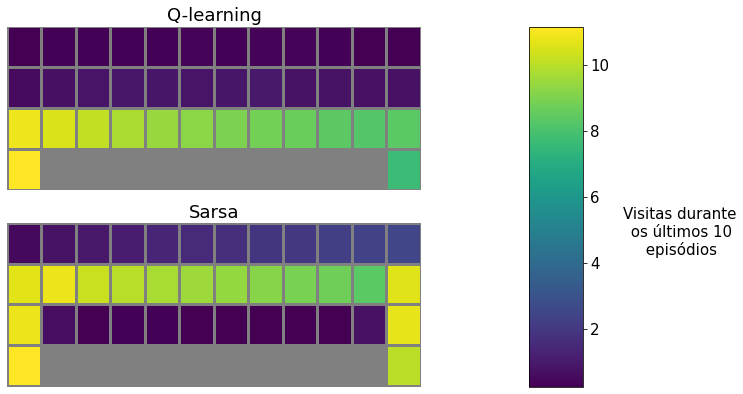

In [10]:
for algorithm, position in [("Q-learning", 211), ("Sarsa", 212)]:
    plt.subplot(position)
    average_state_visits = np.array(all_state_visits[algorithm]).mean(axis=0)
    grid_state_visits = average_state_visits.reshape((4,12))
    grid_state_visits[0,1:-1] = np.nan
    plt.pcolormesh(grid_state_visits, edgecolors='gray', linewidth=2)
    plt.title(algorithm)
    plt.axis('off')
    cm = plt.get_cmap()
    cm.set_bad('gray')

    plt.subplots_adjust(bottom=0.0, right=0.7, top=1.0)
    cax = plt.axes([0.85, 0.0, 0.075, 1.])
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel("Visitas durante\n os últimos 10\n episódios", rotation=0, labelpad=70)
plt.show()

O agente **Q-learning** aprende a política ideal se movendo ao longo do penhasco e atinge a meta com o mínimo de passos possível. No entanto, como o agente não segue a política ótima e usa a exploração $\epsilon$-greedy, ele ocasionalmente cai do penhasco. 

O agente **Sarsa** segue um caminho mais seguro.

No experimento anterior usamos um time-step fixo de 0,5 para os agentes. Agora, qual seria o comportamento do algoritmo para outros time-steps? Como fica o desempenho dos agentes?

No próximo experimento vamos realizar a execução para 10 time-steps diferentes (de 0,1 a 1,0) e vamos comparar a soma das recompensas por episódio em média durante os primeiros 100 episódios.

Note que esta célula demora cerca de 10 minutos para executar.

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

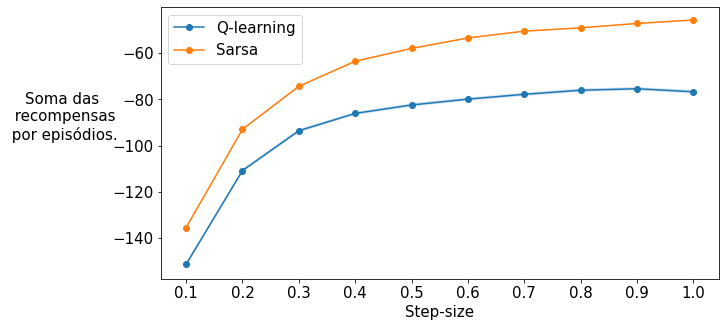

In [11]:
agents = {
    "Q-learning": QLearningAgent,
    "Sarsa": SarsaAgent
}
env = Environment
all_reward_sums = {}
step_sizes = np.linspace(0.1,1.0,10)
agent_info = {"num_actions": 4, "num_states": 48, "epsilon": 0.1, "discount": 1.0}
env_info = {}
num_runs = 100
num_episodes = 100
all_reward_sums = {}

for algorithm in ["Q-learning", "Sarsa"]:
    for step_size in step_sizes:
        all_reward_sums[(algorithm, step_size)] = []
        agent_info["step_size"] = step_size
        for run in tqdm(range(num_runs)):
            agent_info["seed"] = run
            rl_glue = RLGlue(env, agents[algorithm])
            rl_glue.rl_init(agent_info, env_info)

            return_sum = 0
            for episode in range(num_episodes):
                rl_glue.rl_episode(0)
                return_sum += rl_glue.rl_return()
            all_reward_sums[(algorithm, step_size)].append(return_sum/num_episodes)
        

for algorithm in ["Q-learning", "Sarsa"]:
    algorithm_means = np.array([np.mean(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    algorithm_stds = np.array([sem(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    plt.plot(step_sizes, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    plt.fill_between(step_sizes, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

plt.legend()
plt.xlabel("Step-size")
plt.ylabel("Soma das\n recompensas\n por episódios.",rotation=0, labelpad=50)
plt.xticks(step_sizes)
plt.show()

Note que o Sarsa se mostra mais eficiente do que o Q-Learning neste problema para uma vasta gama de step-sizes.